In [72]:
from time import sleep
from collections import namedtuple, deque
import matplotlib.pyplot as plt


%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
import random

from pettingzoo.classic import connect_four_v3

import pygame

In [73]:
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [74]:
#env = connect_four_v3.env(render_mode="human")
env = connect_four_v3.env()
env.reset()


#Numero de iteraciones
num_episodes = 4000


In [75]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 0.0001
TAU = 0.0001
LR = 3e-4

In [76]:
# Get number of actions from gym action space
n_actions = 7

# Get the number of state observations
observation, reward, termination, truncation, info = env.last()

#observation_shape = np.array(observation["observation"]).reshape(1,-1)
n_observations = 84




In [77]:
class ActorNetwork(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(ActorNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [78]:
class CriticNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(CriticNetwork, self).__init__()
        self.linear1 = nn.Linear(state_size, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

In [79]:
class SAC:
    def __init__(self,lr,batch_size,gamma,tau, eps_start,eps_end,eps_dec, n_observations,n_actions):
        
        self.lr = lr
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.epsilon = eps_start
        self.eps_end = eps_end
        self.eps_dec = eps_dec
        
        self.n_observations = n_observations
        self.n_actions = n_actions

        self.policy_net = ActorNetwork(n_observations, n_actions).to(device)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=LR, amsgrad=True)

        self.critic_net_1 = CriticNetwork(n_observations, n_actions).to(device)
        self.critic_optimizer_1 = optim.Adam(self.critic_net_1.parameters(), lr=LR, amsgrad=True)
        self.critic_net_2 = CriticNetwork(n_observations, n_actions).to(device)
        self.critic_optimizer_2 = optim.Adam(self.critic_net_2.parameters(), lr=LR, amsgrad=True)

        self.target_net_1 = CriticNetwork(n_observations, n_actions).to(device)
        self.target_optimizer_1 = optim.Adam(self.target_net_1.parameters(), lr=LR, amsgrad=True)
        self.target_net_2 = CriticNetwork(n_observations, n_actions).to(device)
        self.target_optimizer_2 = optim.Adam(self.target_net_2.parameters(), lr=LR, amsgrad=True)


        self.memory = []

        self.value_criterion = nn.MSELoss()
        self.criterion_1 = nn.MSELoss()
        self.criterion_2 = nn.MSELoss()
        self.probs = []
        self.loss = 0




    def choose_action(self, agent, state):
        if np.random.random() < self.epsilon:
            action = env.action_space(agent).sample(state["action_mask"])
        else:
            action_mask = torch.tensor(state["action_mask"])
            state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))
            
            q_values = self.policy_net(state_tensor)
            max, min= torch.max(q_values), torch.min(q_values)
            q_values = (q_values-min)/ (max-min)
            valid_actions = action_mask *  q_values

            print(valid_actions)

            #self.probs = valid_actions

            action = np.argmax(valid_actions.detach().numpy())


            #self.policy_net.train()
            self.decrement_epsilon()

        return action
    
    def update(self, state, new_state, reward,done):
        
        
        
        state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))
        new_state_tensor = torch.FloatTensor(np.array(new_state["observation"]).reshape(1,-1))

        next_action_prob = self.policy_net(state_tensor)


        next_q_target_1 = self.target_net_1(new_state_tensor)
        next_q_target_2 = self.target_net_2(new_state_tensor)

        min_next_q_target = torch.min(next_q_target_1, next_q_target_2)
        next_q = (100 * reward) + (1 - done) * self.gamma * (min_next_q_target - next_action_prob)

        Value_1 = self.critic_net_1(state_tensor)
        value_2 = self.critic_net_2(state_tensor)

        loss_1 = self.criterion_1(Value_1,next_q)
        loss_2 = self.criterion_2(value_2,next_q)

        self.loss = (loss_1 + loss_2)/2

        self.policy_optimizer.zero_grad()
        self.critic_optimizer_1.zero_grad()
        self.critic_optimizer_2.zero_grad()
        self.target_optimizer_1.zero_grad()
        self.target_optimizer_2.zero_grad()

        self.loss.backward()
        
        self.policy_optimizer.step()
        self.critic_optimizer_1.step()
        self.critic_optimizer_2.step()
        self.target_optimizer_1.step()
        self.target_optimizer_2.step()




    def update_memory(self,state, reward, termination, truncation, info):
        self.memory.append((state, reward, termination, truncation, info))

    def clear_memory(self):
        self.memory = []


    def optimize(self):
        self.policy_optimizer.zero_grad()
        self.critic_optimizer_1.zero_grad()
        self.critic_optimizer_2.zero_grad()
        self.target_optimizer_1.zero_grad()
        self.target_optimizer_2.zero_grad()
        
        self.policy_optimizer.step()
        self.critic_optimizer_1.step()
        self.critic_optimizer_2.step()
        self.target_optimizer_1.step()
        self.target_optimizer_2.step()
    
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_end else self.eps_end
    


In [80]:


sac_agent_0 = SAC(lr=LR,gamma=GAMMA,batch_size=BATCH_SIZE,tau=TAU,
                eps_start=EPS_START,eps_end=EPS_END,eps_dec=EPS_DECAY,
                n_observations=n_observations,n_actions=n_actions)

sac_agent_1 = SAC(lr=LR,gamma=GAMMA,batch_size=BATCH_SIZE,tau=TAU,
                eps_start=EPS_START,eps_end=EPS_END,eps_dec=EPS_DECAY,
                n_observations=n_observations,n_actions=n_actions)

sac_agent_a = SAC(lr=LR,gamma=GAMMA,batch_size=BATCH_SIZE,tau=TAU,
                eps_start=EPS_START,eps_end=EPS_END,eps_dec=EPS_DECAY,
                n_observations=n_observations,n_actions=n_actions)


In [81]:
# Inicializa pygame
#pygame.init()

# Crea la ventana
#screen = pygame.display.set_mode ( (400,400),pygame.RESIZABLE )
#pygame.VIDEORESIZE

agent_0_score = []
agent_1_score = []



total_reward_player_0 = 0
total_reward_player_1 = 0
last_action_player_0 = 0
last_action_player_1 = 0

previous_state = observation

for episode in range(num_episodes):
    state = env.reset()
    
    #Definicion del primer jugador en cada partida
    if(episode % 2 == 1):
        for agent in env.agent_iter():
            
            state, reward, termination, truncation, info = env.last()


            if termination or truncation:
                    #print(env.rewards)
                    total_reward_player_0 = total_reward_player_0 + env.rewards["player_0"]
                    total_reward_player_1 = total_reward_player_1 + env.rewards["player_1"]

                    sac_agent_0.optimize()
                    sac_agent_1.optimize()
                    
                    agent_0_score.append(total_reward_player_0)
                    agent_1_score.append(total_reward_player_1)

                    sac_agent_0.update(previous_state,state,env.rewards["player_0"],termination)
                    sac_agent_1.update(previous_state,state,env.rewards["player_1"],termination)
                    #sac_agent.clear_memory()
                    #sac_agent.learn(previous_state,last_action_player_1,total_reward_player_1,state)

                    break
            
            if(agent == "player_0"):
                action = sac_agent_0.choose_action(agent,state)
                env.step(action)
            else:
                action = sac_agent_1.choose_action(agent,state)
                env.step(action) 
            previous_state = state
        env.close()
    else:
        for agent in env.agent_iter():
            #print(agent)
            state, reward, termination, truncation, info = env.last()


            if termination or truncation:
                    #print(env.rewards)
                    total_reward_player_0 = total_reward_player_0 + env.rewards["player_1"]
                    total_reward_player_1 = total_reward_player_1 + env.rewards["player_0"]

                    sac_agent_0.optimize()
                    sac_agent_1.optimize()
                    
                    agent_0_score.append(total_reward_player_0)
                    agent_1_score.append(total_reward_player_1)

                    sac_agent_0.update(previous_state,state,env.rewards["player_1"],termination)
                    sac_agent_1.update(previous_state,state,env.rewards["player_0"],termination)
                    #sac_agent.clear_memory()
                    #sac_agent.learn(previous_state,last_action_player_1,total_reward_player_1,state)

                    break
            
            if(agent == "player_1"):
                action = sac_agent_0.choose_action(agent,state)
                env.step(action)
            else:
                action = sac_agent_1.choose_action(agent,state)
                env.step(action) 
            previous_state = state
        env.close()
         

print("Total score player 1: " + str(total_reward_player_0))
print("Total score player 2: " + str(total_reward_player_1))


tensor([[0.5687, 1.0000, 0.3280, 0.5282, 0.0000, 0.5199, 0.2983]],
       grad_fn=<MulBackward0>)
tensor([[0.4100, 1.0000, 0.0000, 0.3393, 0.0000, 0.4960, 0.2675]],
       grad_fn=<MulBackward0>)
tensor([[0.2341, 0.0000, 0.6378, 1.0000, 0.4945, 0.6873, 0.3344]],
       grad_fn=<MulBackward0>)
tensor([[0.3685, 0.0000, 0.7341, 0.9797, 0.5732, 1.0000, 0.3014]],
       grad_fn=<MulBackward0>)
tensor([[0.4641, 0.0000, 0.6290, 1.0000, 0.6004, 0.8932, 0.2726]],
       grad_fn=<MulBackward0>)
tensor([[0.6229, 1.0000, 0.4127, 0.8594, 0.0000, 0.4030, 0.2349]],
       grad_fn=<MulBackward0>)
tensor([[0.6730, 1.0000, 0.4523, 0.6682, 0.0000, 0.5443, 0.2599]],
       grad_fn=<MulBackward0>)
tensor([[0.6367, 1.0000, 0.4512, 0.6097, 0.0000, 0.4825, 0.2713]],
       grad_fn=<MulBackward0>)
tensor([[0.6042, 1.0000, 0.2297, 0.8321, 0.0000, 0.6130, 0.2691]],
       grad_fn=<MulBackward0>)
tensor([[0.6815, 1.0000, 0.3742, 0.7810, 0.0000, 0.6630, 0.4212]],
       grad_fn=<MulBackward0>)
tensor([[0.0000, 0.2

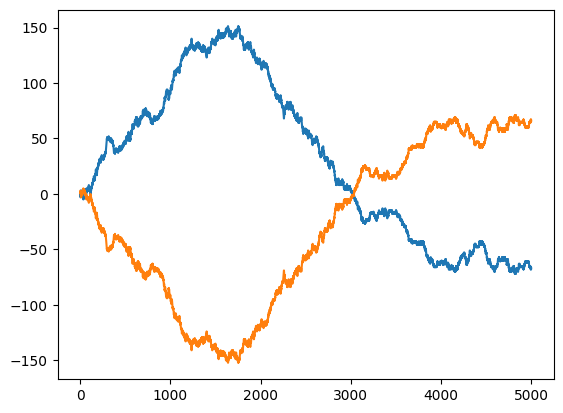

In [82]:
plt.plot(agent_0_score)
plt.plot(agent_1_score)
plt.show()

In [83]:
agent_score_a = []
agent_score_r = []

# Jugadores: A (agente solitario) , R (movimientos random)

total_reward_player_a = 0
total_reward_player_r = 0
last_action_player_a = 0
last_action_player_r = 0

env.reset()
previous_state = observation

for episode in range(num_episodes):
    state = env.reset()

    #Definicion del primer jugador en cada partida
    if(episode % 2 == 1):
        for agent in env.agent_iter():
            #print(agent)
            state, reward, termination, truncation, info = env.last()

            if termination or truncation:
                    #print(env.rewards)
                    total_reward_player_a = total_reward_player_a + env.rewards["player_0"]
                    total_reward_player_r = total_reward_player_r + env.rewards["player_1"]

                    sac_agent_a.optimize()
                    
                    agent_score_a.append(total_reward_player_a)
                    agent_score_r.append(total_reward_player_r)

                    sac_agent_a.update(previous_state,state,env.rewards["player_0"],termination)
                    #sac_agent.update(previous_state,state,env.rewards["player_1"],termination)
                    #sac_agent.clear_memory()
                    #sac_agent.learn(previous_state,last_action_player_1,total_reward_player_1,state)

                    break
            
            if(agent == "player_0"):
                action = sac_agent_a.choose_action(agent,state)
                env.step(action)
            else:
                mask = state["action_mask"]
                action = env.action_space(agent).sample(mask)
                env.step(action) 
            previous_state = state
        env.close()
    else:
        for agent in env.agent_iter():
            #print(agent)
            state, reward, termination, truncation, info = env.last()


            if termination or truncation:
                    #print(env.rewards)
                    total_reward_player_a = total_reward_player_a + env.rewards["player_1"]
                    total_reward_player_r = total_reward_player_r + env.rewards["player_0"]

                    sac_agent_a.optimize()
                    
                    agent_score_a.append(total_reward_player_a)
                    agent_score_r.append(total_reward_player_r)

                    sac_agent_a.update(previous_state,state,env.rewards["player_1"],termination)
                    #sac_agent.update(previous_state,state,reward,termination)
                    #sac_agent.clear_memory()
                    #sac_agent.learn(previous_state,last_action_player_1,total_reward_player_1,state)

                    break
            
            if(agent == "player_1"):
                action= sac_agent_a.choose_action(agent,state)
                env.step(action) 
            else:
                mask = state["action_mask"]
                action = env.action_space(agent).sample(mask)
                env.step(action) 
            previous_state = state
        env.close()
         

print("Total score player 1: " + str(total_reward_player_a))
print("Total score player 2: " + str(total_reward_player_r))

tensor([[0.9579, 0.0000, 0.9644, 0.3384, 1.0000, 0.8985, 0.6889]],
       grad_fn=<MulBackward0>)
tensor([[0.8137, 0.0000, 0.7906, 0.3275, 1.0000, 0.6656, 0.5491]],
       grad_fn=<MulBackward0>)
tensor([[1.0000, 0.0000, 0.8834, 0.2188, 0.9681, 0.9416, 0.5888]],
       grad_fn=<MulBackward0>)
tensor([[1.0000, 0.0000, 0.7443, 0.1838, 0.7084, 0.8638, 0.6172]],
       grad_fn=<MulBackward0>)
tensor([[0.0000, 0.0000, 0.5678, 0.1819, 0.7385, 0.7409, 0.5235]],
       grad_fn=<MulBackward0>)
tensor([[1.0000, 0.0694, 0.9072, 0.0000, 0.8925, 0.9170, 0.4800]],
       grad_fn=<MulBackward0>)
tensor([[1.0000, 0.0000, 0.8865, 0.3062, 0.8323, 0.8146, 0.5038]],
       grad_fn=<MulBackward0>)
tensor([[0.9977, 0.0000, 0.8448, 0.5631, 0.6503, 1.0000, 0.7889]],
       grad_fn=<MulBackward0>)
tensor([[1.0000, 0.0000, 0.9220, 0.2945, 0.7770, 0.8378, 0.4342]],
       grad_fn=<MulBackward0>)
tensor([[1.0000, 0.0000, 0.9290, 0.2187, 0.8987, 0.8639, 0.4806]],
       grad_fn=<MulBackward0>)
tensor([[0.9225, 0.0

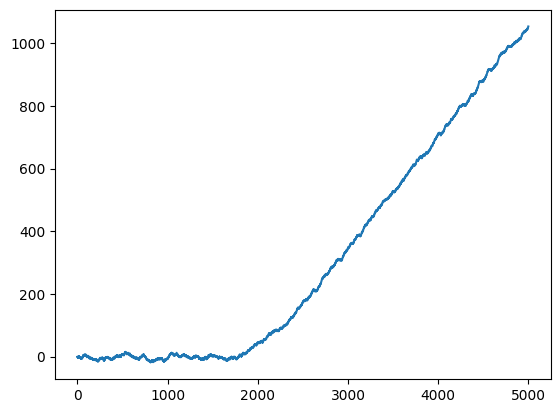

In [84]:
plt.plot(agent_score_a)
plt.show()

In [85]:
"""
Referencias:

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
https://pettingzoo.farama.org/content/basic_usage/
https://medium.com/analytics-vidhya/soft-actor-critic-algorithms-in-deep-reinforcement-learning-a11bedd9aa20
https://github.com/haarnoja/sac/blob/master/sac/algos/sac.py
https://github.com/shakti365/soft-actor-critic/blob/master/src/sac.py
https://github.com/pranz24/pytorch-soft-actor-critic/blob/master/sac.py
https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/sac_continuous_action.py
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/sac/core.py
https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f
https://github.com/yc930401/Actor-Critic-pytorch/blob/master/Actor-Critic.py
https://github.com/chengxi600/RLStuff/blob/master/Actor-Critic/Off-Policy_Actor_Critic.ipynb
https://gist.github.com/jskDr/9173432937ca00755be849f14672e98c
https://www.toptal.com/deep-learning/pytorch-reinforcement-learning-tutorial
https://pylessons.com/Epsilon-Greedy-DQN
https://github.com/Felhof/DiscreteSAC/blob/main/Discrete_SAC_Agent.py
https://github.com/vy007vikas/PyTorch-ActorCriticRL/blob/master/train.py
https://github.com/thomashirtz/soft-actor-critic/tree/main
https://towardsdatascience.com/soft-actor-critic-demystified-b8427df61665
https://towardsdatascience.com/adapting-soft-actor-critic-for-discrete-action-spaces-a20614d4a50a


"""

'\nReferencias:\n\nhttps://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html\nhttps://pettingzoo.farama.org/content/basic_usage/\nhttps://medium.com/analytics-vidhya/soft-actor-critic-algorithms-in-deep-reinforcement-learning-a11bedd9aa20\nhttps://github.com/haarnoja/sac/blob/master/sac/algos/sac.py\nhttps://github.com/shakti365/soft-actor-critic/blob/master/src/sac.py\nhttps://github.com/pranz24/pytorch-soft-actor-critic/blob/master/sac.py\nhttps://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/sac_continuous_action.py\nhttps://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html\nhttps://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/sac/core.py\nhttps://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f\nhttps://github.com/yc930401/Actor-Critic-pytorch/blob/master/Actor-Critic.py\nhttps://github.com/chengxi600/RLStuff/blob/master/Actor-Critic/Off-Policy_Actor_Critic.ipynb\nhttps://gist.github.com/jskDr/9173432937ca00755be